# Final Image Preprocessing Pipeline

### Importing libraries and defining functions to load sample images from the "CROPPED" folder for each cell category

In [72]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.metrics import structural_similarity as ssim
import warnings
from tqdm import tqdm
from datetime import datetime

# --- Configuration ---

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# NOTE: Updated paths as per your request
BASE_DIR = Path(r"c:\Meet\Projects\Project_8_Phoenix_Cervical Cancer Image Classification\Project-Phoenix")
RAW_DATASET_PATH = BASE_DIR / "Dataset" / "Raw Dataset" / "SipakMed Dataset"
OUTPUT_DIR = BASE_DIR / "Dataset" / "Preprocessing Analysis v3.0"

# Create output directory structure if it doesn't exist
OUTPUT_DIR.mkdir(exist_ok=True)
(OUTPUT_DIR / "visualizations").mkdir(exist_ok=True)
(OUTPUT_DIR / "processed_samples").mkdir(exist_ok=True)
(OUTPUT_DIR / "metrics").mkdir(exist_ok=True)


# Processing Configuration
TARGET_SIZE = (256, 256)
# MODIFIED: Changed samples per class back to 3
SAMPLES_PER_CLASS = 3 

# Final Pipeline Hyperparameters
NLM_PARAMS = {'h': 3, 'templateWindowSize': 7, 'searchWindowSize': 21}
CLAHE_PARAMS = {'clipLimit': 1.2, 'tileGridSize': (6, 6)}

# Cell Categories
CLASS_NAMES = [
    'im_Dyskeratotic',
    'im_Koilocytotic',
    'im_Metaplastic',
    'im_Parabasal',
    'im_Superficial-Intermediate'
]

# Matplotlib settings for better visualizations
plt.rcParams['figure.figsize'] = (18, 24)
plt.rcParams['figure.dpi'] = 100
plt.style.use('seaborn-v0_8-darkgrid')

print("Configuration Setup Complete ✅")
print(f"Dataset Path: {RAW_DATASET_PATH}")
print(f"Output Directory: {OUTPUT_DIR}")
print(f"Analysis Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("-" * 50)


Configuration Setup Complete ✅
Dataset Path: c:\Meet\Projects\Project_8_Phoenix_Cervical Cancer Image Classification\Project-Phoenix\Dataset\Raw Dataset\SipakMed Dataset
Output Directory: c:\Meet\Projects\Project_8_Phoenix_Cervical Cancer Image Classification\Project-Phoenix\Dataset\Preprocessing Analysis v3.0
Analysis Timestamp: 2025-08-28 15:49:23
--------------------------------------------------


### Function to standardize the cell images while maintaining the aspect ratio

In [73]:
def resize_with_aspect_ratio_mirroring(image, target_size=(256, 256)):
    """
    Resize image to target size while preserving aspect ratio using mirroring for padding.
    
    Args:
        image: Input image (numpy array)
        target_size: Tuple of (width, height) for target size
        
    Returns:
        resized_image: Image resized to target size with aspect ratio preserved
        scale_factor: The scaling factor applied
        padding_info: Dictionary containing padding information
    """
    h, w = image.shape[:2]
    target_w, target_h = target_size
    
    # Calculate scaling factor to fit the image within target size
    scale_w = target_w / w
    scale_h = target_h / h
    scale = min(scale_w, scale_h)  # Use smaller scale to maintain aspect ratio
    
    # Calculate new dimensions after scaling
    new_w = int(w * scale)
    new_h = int(h * scale)
    
    # Resize the image with the calculated scale
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LANCZOS4)
    
    # Calculate padding needed
    pad_w = target_w - new_w
    pad_h = target_h - new_h
    
    # Calculate padding for each side
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left
    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top
    
    # Create the final image with mirroring using cv2.copyMakeBorder for efficiency
    final_image = cv2.copyMakeBorder(resized, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_REFLECT_101)
    
    padding_info = {
        'original_size': (w, h),
        'scaled_size': (new_w, new_h),
        'padding': {'top': pad_top, 'bottom': pad_bottom, 'left': pad_left, 'right': pad_right},
        'scale_factor': scale
    }
    
    return final_image, scale, padding_info


### Function to apply the preprocessing pipeline

In [74]:
def apply_preprocessing_pipeline(image, nlm_params, clahe_params):
    """
    Applies the full NLM -> CLAHE preprocessing pipeline to an image.
    This version uses a channel-wise approach for both NLM and CLAHE (RGB).

    Args:
        image (np.array): Input BGR image.
        nlm_params (dict): Parameters for NLM denoising.
        clahe_params (dict): Parameters for CLAHE.

    Returns:
        tuple: A tuple containing the NLM-denoised image and the final CLAHE-enhanced image.
    """
    # 1. NLM Denoising (Channel-wise)
    b, g, r = cv2.split(image)
    b_nlm = cv2.fastNlMeansDenoising(b, None, **nlm_params)
    g_nlm = cv2.fastNlMeansDenoising(g, None, **nlm_params)
    r_nlm = cv2.fastNlMeansDenoising(r, None, **nlm_params)
    nlm_denoised = cv2.merge((b_nlm, g_nlm, r_nlm))

    # 2. CLAHE Enhancement (RGB Pipeline)
    b_clahe_in, g_clahe_in, r_clahe_in = cv2.split(nlm_denoised)
    clahe = cv2.createCLAHE(**clahe_params)
    b_clahe_out = clahe.apply(b_clahe_in)
    g_clahe_out = clahe.apply(g_clahe_in)
    r_clahe_out = clahe.apply(r_clahe_in)
    final_image = cv2.merge((b_clahe_out, g_clahe_out, r_clahe_out))

    return nlm_denoised, final_image


### Helper functions to calculate the evaluation metrics

In [75]:
def calculate_psnr(original, processed):
    """Calculates Peak Signal-to-Noise Ratio."""
    mse = np.mean((original.astype(np.float64) - processed.astype(np.float64)) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))

def calculate_ssim(original, processed):
    """Calculates Structural Similarity Index."""
    original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    processed_gray = cv2.cvtColor(processed, cv2.COLOR_BGR2GRAY)
    return ssim(original_gray, processed_gray, data_range=255)

def calculate_epi_ratio(original, processed):
    """Calculates the Edge Preservation Index (EPI) ratio."""
    def get_gradient_magnitude(img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        return np.mean(np.sqrt(grad_x**2 + grad_y**2))

    epi_original = get_gradient_magnitude(original)
    epi_processed = get_gradient_magnitude(processed)
    return epi_processed / epi_original if epi_original != 0 else 0

def calculate_contrast_improvement(original, processed):
    """
    Calculates contrast improvement as the ratio of standard deviations of pixel intensities.
    This serves as a proxy for CNR improvement without needing explicit ROI.
    """
    def get_contrast(image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return np.std(gray)

    contrast_original = get_contrast(original)
    contrast_processed = get_contrast(processed)
    return contrast_processed / contrast_original if contrast_original != 0 else 0


### Function to implement and visualize the preprocessing steps

In [76]:
def process_and_visualize():
    """
    Main function to load images from CROPPED folders, process them,
    calculate metrics, and generate the final visualization.
    """
    print("Starting image processing and analysis...\n")
    results = {}

    if not RAW_DATASET_PATH.exists():
        print(f"❌ ERROR: Dataset path not found at '{RAW_DATASET_PATH}'")
        return

    for class_name in CLASS_NAMES:
        cropped_path = RAW_DATASET_PATH / class_name / class_name / "CROPPED"

        if not cropped_path.exists():
            print(f"Warning: CROPPED path not found for {class_name}, skipping.")
            continue

        image_files = sorted(list(cropped_path.glob('*.bmp')))
        
        if not image_files:
            print(f"Warning: No images found for {class_name}.")
            continue
        
        # MODIFIED: Select 3 evenly distributed sample images
        if len(image_files) < SAMPLES_PER_CLASS:
            print(f"Warning: Only {len(image_files)} images found for {class_name}. Using all.")
            selected_files = image_files
        else:
            step = len(image_files) // SAMPLES_PER_CLASS
            selected_files = [image_files[i * step] for i in range(SAMPLES_PER_CLASS)]

        class_results = []
        for img_file in tqdm(selected_files, desc=f"Processing {class_name}"):
            original_image = cv2.imread(str(img_file))
            if original_image is None:
                continue

            resized_original, _, _ = resize_with_aspect_ratio_mirroring(original_image, TARGET_SIZE)
            nlm_image, final_image = apply_preprocessing_pipeline(resized_original, NLM_PARAMS, CLAHE_PARAMS)
            # Calculate all metrics
            psnr_val = calculate_psnr(resized_original, final_image)
            ssim_val = calculate_ssim(resized_original, final_image)
            epi_ratio_val = calculate_epi_ratio(resized_original, final_image)
            cnr_imp_val = calculate_contrast_improvement(resized_original, final_image)

            class_results.append({
                'filename': img_file.name,
                'original': resized_original,
                'nlm': nlm_image,
                'final': final_image,
                'metrics': {
                    'PSNR': psnr_val,
                    'SSIM': ssim_val,
                    'EPI Ratio': epi_ratio_val,
                    'CNR Imp.': cnr_imp_val
                }
            })
        results[class_name] = class_results

    # --- Visualization ---
    print("\nGenerating visualization...")
    fig, axes = plt.subplots(
        len(CLASS_NAMES),
        SAMPLES_PER_CLASS * 3, # 3 samples * 3 versions = 9 columns
        figsize=(20, 15), 
        constrained_layout=True
    )
    fig.suptitle('Cervical Cell Preprocessing: Before & After Comparison', fontsize=24, weight='bold')

    for i, class_name in enumerate(CLASS_NAMES):
        if class_name not in results or not results[class_name]:
            for j in range(SAMPLES_PER_CLASS * 3):
                ax = axes[i, j]
                if j % 3 == 1:
                     ax.text(0.5, 0.5, f'{class_name.replace("im_", "")}\nNot Found', ha='center', va='center')
                ax.set_xticks([])
                ax.set_yticks([])
                ax.axis('off')
            continue

        for j, data in enumerate(results[class_name]):
            col_orig = j * 3
            col_nlm = j * 3 + 1
            col_final = j * 3 + 2

            # Plot Original Image
            ax_orig = axes[i, col_orig]
            ax_orig.imshow(cv2.cvtColor(data['original'], cv2.COLOR_BGR2RGB))
            ax_orig.set_title(f"{data['filename']}\nOriginal", fontsize=10)
            ax_orig.set_xticks([])
            ax_orig.set_yticks([])
            if j == 0:
                ax_orig.set_ylabel(class_name.replace('im_', ''), fontsize=14, weight='bold', labelpad=20)

            # Plot NLM Denoised Image
            ax_nlm = axes[i, col_nlm]
            ax_nlm.imshow(cv2.cvtColor(data['nlm'], cv2.COLOR_BGR2RGB))
            ax_nlm.set_title("NLM Denoised", fontsize=10)
            ax_nlm.set_xticks([])
            ax_nlm.set_yticks([])

            # Plot Final (NLM + CLAHE) Image
            ax_final = axes[i, col_final]
            ax_final.imshow(cv2.cvtColor(data['final'], cv2.COLOR_BGR2RGB))
            ax_final.set_title("NLM + CLAHE (Final)", fontsize=10)
            ax_final.set_xticks([])
            ax_final.set_yticks([])

            metrics_str = (
                f"PSNR: {data['metrics']['PSNR']:.2f} dB\n"
                f"SSIM: {data['metrics']['SSIM']:.3f}\n"
                f"EPI Ratio: {data['metrics']['EPI Ratio']:.3f}\n"
                f"CNR Imp.: {data['metrics']['CNR Imp.']:.2f}x"
            )
            ax_final.set_xlabel(metrics_str, fontsize=10, weight='bold')


    output_plot_path = OUTPUT_DIR / "visualizations" / "final_preprocessing_comparison_before_after.png"
    plt.savefig(output_plot_path, bbox_inches='tight')
    print(f"\nVisualization saved to: {output_plot_path} 🖼️")
    plt.show()


Starting image processing and analysis...



Processing im_Dyskeratotic:   0%|          | 0/3 [00:00<?, ?it/s]

Processing im_Superficial-Intermediate: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]



Generating visualization...

Visualization saved to: c:\Meet\Projects\Project_8_Phoenix_Cervical Cancer Image Classification\Project-Phoenix\Dataset\Preprocessing Analysis v3.0\visualizations\final_preprocessing_comparison_before_after.png 🖼️


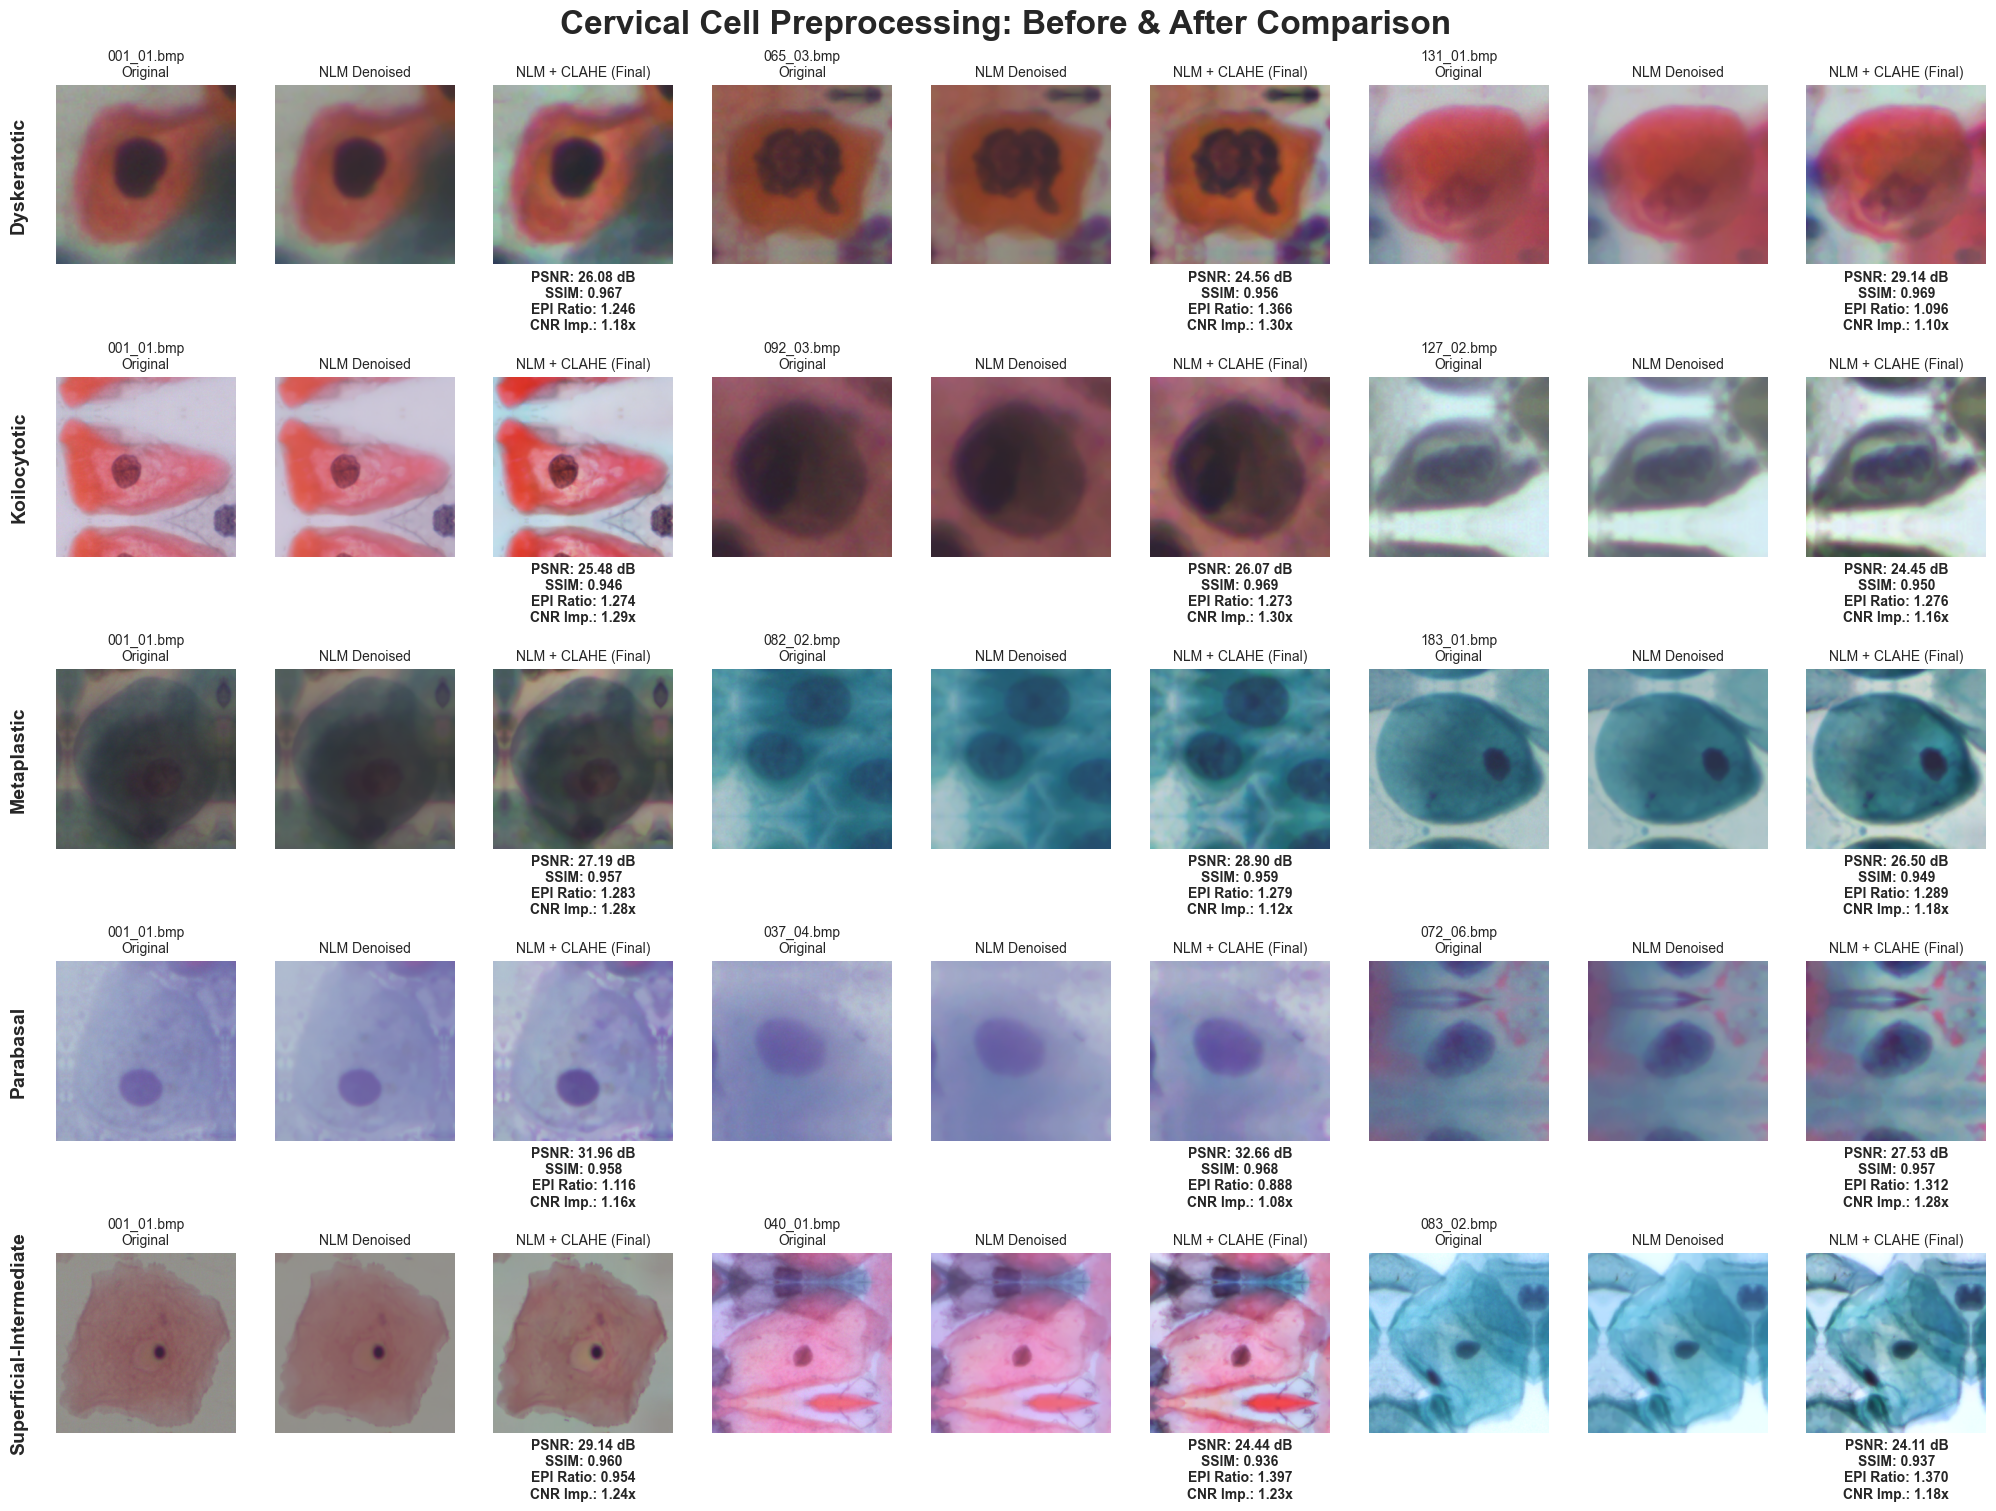

In [77]:
if __name__ == "__main__":
    process_and_visualize()

Starting image processing and analysis...



Processing im_Dyskeratotic:   0%|          | 0/3 [00:00<?, ?it/s]

Processing im_Superficial-Intermediate: 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]



Generating new single-line visualization...

New visualization saved to: c:\Meet\Projects\Project_8_Phoenix_Cervical Cancer Image Classification\Project-Phoenix\Dataset\Preprocessing Analysis v3.0\visualizations\final_preprocessing_single_line.png 🖼️


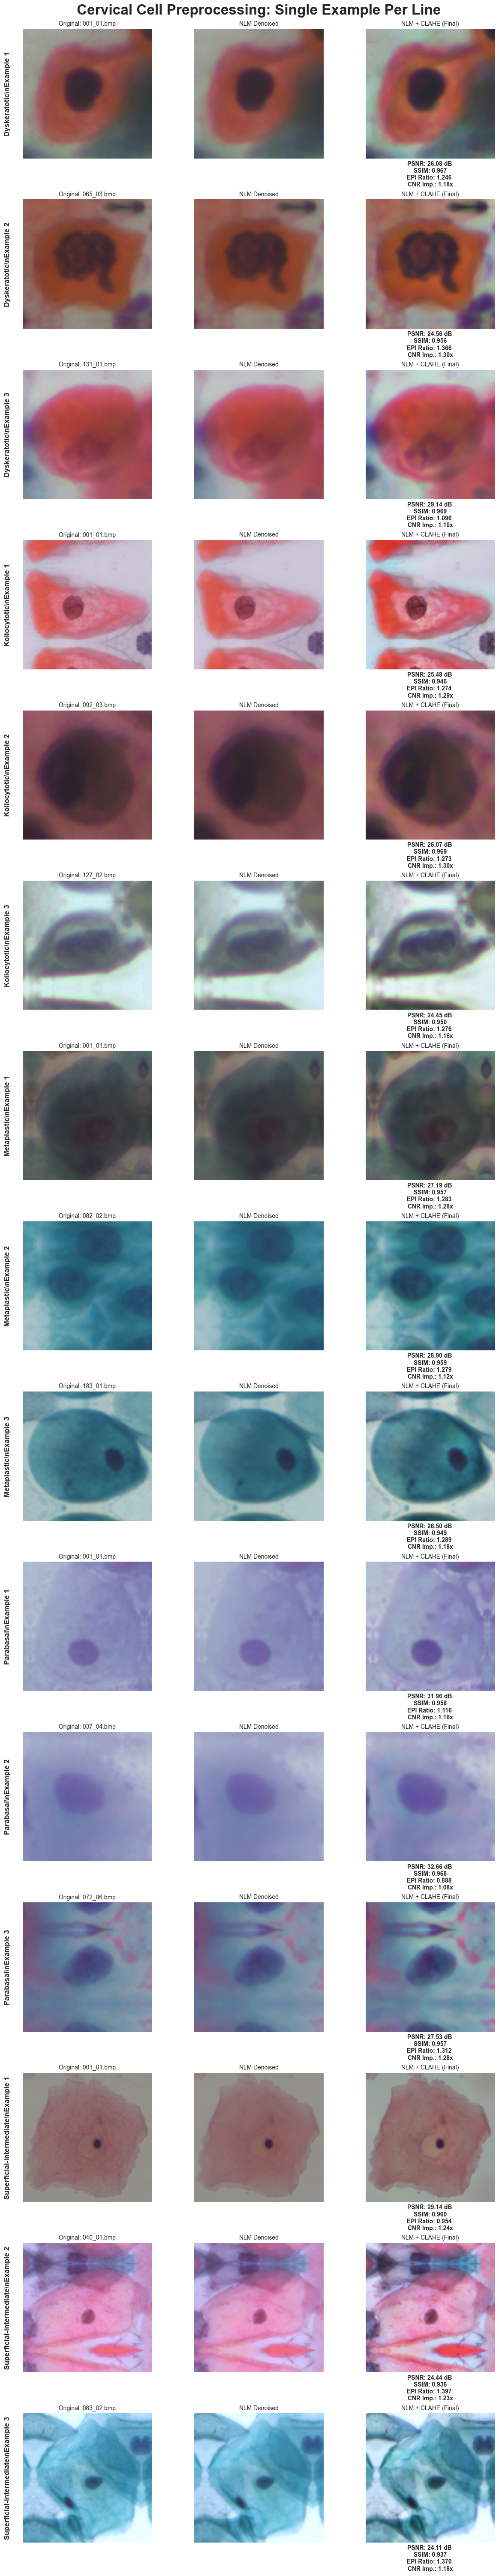

In [80]:
import matplotlib.pyplot as plt
import cv2

def process_and_visualize_single_line(results, CLASS_NAMES, SAMPLES_PER_CLASS, OUTPUT_DIR):
    """
    Generates a visualization with a single cell example per line.
    """
    print("\nGenerating new single-line visualization...")

    # --- New Visualization ---
    # Create a new figure with a layout for one sample per row
    fig, axes = plt.subplots(
        nrows=len(CLASS_NAMES) * SAMPLES_PER_CLASS,
        ncols=3,  # 3 columns for Original, NLM, Final
        figsize=(12, 4 * len(CLASS_NAMES) * SAMPLES_PER_CLASS),
        constrained_layout=True
    )
    fig.suptitle('Cervical Cell Preprocessing: Single Example Per Line', fontsize=24, weight='bold')

    for i, class_name in enumerate(CLASS_NAMES):
        if class_name not in results or not results[class_name]:
            # Handle cases where a class has no images
            for j in range(SAMPLES_PER_CLASS):
                row = i * SAMPLES_PER_CLASS + j
                ax = axes[row, 1] # Use the middle column for the text
                ax.text(0.5, 0.5, f'{class_name.replace("im_", "")}\\nNot Found', ha='center', va='center')
                for col in range(3):
                    axes[row, col].set_xticks([])
                    axes[row, col].set_yticks([])
                    axes[row, col].axis('off')
            continue

        for j, data in enumerate(results[class_name]):
            # Calculate the current row in the subplot grid
            row = i * SAMPLES_PER_CLASS + j

            # Plot Original Image in the first column
            ax_orig = axes[row, 0]
            ax_orig.imshow(cv2.cvtColor(data['original'], cv2.COLOR_BGR2RGB))
            ax_orig.set_title(f"Original: {data['filename']}", fontsize=10)
            ax_orig.set_xticks([])
            ax_orig.set_yticks([])
            # Add the class name as a y-label for each example
            ax_orig.set_ylabel(f'{class_name.replace("im_", "")}\\nExample {j+1}', fontsize=12, weight='bold', labelpad=20)


            # Plot NLM Denoised Image in the second column
            ax_nlm = axes[row, 1]
            ax_nlm.imshow(cv2.cvtColor(data['nlm'], cv2.COLOR_BGR2RGB))
            ax_nlm.set_title("NLM Denoised", fontsize=10)
            ax_nlm.set_xticks([])
            ax_nlm.set_yticks([])

            # Plot Final (NLM + CLAHE) Image in the third column
            ax_final = axes[row, 2]
            ax_final.imshow(cv2.cvtColor(data['final'], cv2.COLOR_BGR2RGB))
            ax_final.set_title("NLM + CLAHE (Final)", fontsize=10)
            ax_final.set_xticks([])
            ax_final.set_yticks([])

            # Add metrics as an x-label to the final image plot
            metrics_str = (
                f"PSNR: {data['metrics']['PSNR']:.2f} dB \n "
                f"SSIM: {data['metrics']['SSIM']:.3f} \n"
                f"EPI Ratio: {data['metrics']['EPI Ratio']:.3f} \n"
                f"CNR Imp.: {data['metrics']['CNR Imp.']:.2f}x"
            )
            ax_final.set_xlabel(metrics_str, fontsize=10, weight='bold')

    # Save the new visualization
    output_plot_path = OUTPUT_DIR / "visualizations" / "final_preprocessing_single_line.png"
    plt.savefig(output_plot_path, bbox_inches='tight')
    print(f"\nNew visualization saved to: {output_plot_path} 🖼️")
    plt.show()

# Ensure 'results' is available by running the processing function and capturing its output.
def process_and_visualize_return_results():
    """
    Modified version of process_and_visualize that returns the results dictionary.
    """
    print("Starting image processing and analysis...\n")
    results = {}

    if not RAW_DATASET_PATH.exists():
        print(f"❌ ERROR: Dataset path not found at '{RAW_DATASET_PATH}'")
        return None

    for class_name in CLASS_NAMES:
        cropped_path = RAW_DATASET_PATH / class_name / class_name / "CROPPED"

        if not cropped_path.exists():
            print(f"Warning: CROPPED path not found for {class_name}, skipping.")
            continue

        image_files = sorted(list(cropped_path.glob('*.bmp')))
        
        if not image_files:
            print(f"Warning: No images found for {class_name}.")
            continue
        
        # MODIFIED: Select 3 evenly distributed sample images
        if len(image_files) < SAMPLES_PER_CLASS:
            print(f"Warning: Only {len(image_files)} images found for {class_name}. Using all.")
            selected_files = image_files
        else:
            step = len(image_files) // SAMPLES_PER_CLASS
            selected_files = [image_files[i * step] for i in range(SAMPLES_PER_CLASS)]

        class_results = []
        for img_file in tqdm(selected_files, desc=f"Processing {class_name}"):
            original_image = cv2.imread(str(img_file))
            if original_image is None:
                continue

            resized_original, _, _ = resize_with_aspect_ratio_mirroring(original_image, TARGET_SIZE)
            nlm_image, final_image = apply_preprocessing_pipeline(resized_original, NLM_PARAMS, CLAHE_PARAMS)
            # Calculate all metrics
            psnr_val = calculate_psnr(resized_original, final_image)
            ssim_val = calculate_ssim(resized_original, final_image)
            epi_ratio_val = calculate_epi_ratio(resized_original, final_image)
            cnr_imp_val = calculate_contrast_improvement(resized_original, final_image)

            class_results.append({
                'filename': img_file.name,
                'original': resized_original,
                'nlm': nlm_image,
                'final': final_image,
                'metrics': {
                    'PSNR': psnr_val,
                    'SSIM': ssim_val,
                    'EPI Ratio': epi_ratio_val,
                    'CNR Imp.': cnr_imp_val
                }
            })
        results[class_name] = class_results

    return results

# Run the processing and visualization
results = process_and_visualize_return_results()
if results is not None:
    process_and_visualize_single_line(results, CLASS_NAMES, SAMPLES_PER_CLASS, OUTPUT_DIR)
else:
    print("Please check your dataset path and try again.")